In [ ]:
!nvidia-smi

Sat Oct 10 03:59:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
# basic modules
import os
import re
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# to read files
from tqdm import tqdm
import glob
from PIL import Image
import json
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
path = '/content/gdrive/My Drive/Dacon/Arirang/'
path_train = path + 'train/'  # use glob
path_test = path + 'test/'  # use glob
path_submission = path + 'sample_submission.csv'
model_dir = '/content/gdrive/My Drive/Dacon/Arirang/retinanet/adam2/'

batch_size = 2
epochs = 100

In [ ]:
def check_image_size(imgs):
    for i in range(len(imgs)-1):
        if imgs[i].shape != imgs[i+1].shape:
            print(f"image shape different for index {i}, {i+1} as {imgs[i].shape}, {imgs[i+1].shape}")
            return False
    return True

def check_file_order(files_images, files_jsons):
    for im, js in zip(files_images, files_jsons):
        if im.replace('images/','').replace('.png','') != js.replace('json/','').replace('.json',''):
            print(f'{im} and {js} does not match')
            return False
    return True

def convert_8coords_to_4coords(coords):
    x_coords = coords[0::2]
    y_coords = coords[1::2]
    xmin, ymin, xmax, ymax = min(x_coords), min(y_coords), max(x_coords), max(y_coords)
    w, h = xmax-xmin, ymax-ymin
    return [xmin + w/2, ymin + h/2, w, h]  # returns center

def import_dataset():
    files_images = sorted(glob.glob(path_train + 'images' + '/*.png'))  # 여기 sort 를 해줘야 서로 맞는다.
    files_jsons = sorted(glob.glob(path_train + 'json' + '/*.json'))
    # print("Are ordered image and json filename match : ", check_file_order(files_images, files_jsons))
    files = zip(files_images, files_jsons)
    imgs, bboxs, ids, names = [], [], [], []
    tqdm_map = {path : i+1 for i, path in enumerate(files)}
    for path_image, path_json in tqdm(tqdm_map, desc='loading the training data'):
        img, label = Image.open(path_image), json.load(open(path_json))
        bbox, id, name = [], [], []
        for target in label['features']:
            item = target['properties']
            bbox.append( convert_8coords_to_4coords([np.float32(num) for num in item['object_imcoords'].split(",")]) )
            id.append( int(item['type_id']) )
            name.append( item['type_name'] )
        imgs.append(np.array(img))
        bboxs.append(np.array(bbox, dtype = 'float32'))
        ids.append(np.array(id, dtype = 'float32'))
        names.append(np.array(name))
    # print("Are image sizes same : ", check_image_size(imgs)) : True
    return imgs, bboxs, ids, names  # list 안에 numpy 들이 들어가있는 꼴이다.

imgs, bboxs, ids, names = import_dataset()

loading the training data: 100%|██████████| 800/800 [12:43<00:00,  1.05it/s]


In [ ]:
def get_int2str(ids, names):
    int2str = {}
    for id, name in zip(ids, names):
        for i, nam in zip(id, name):
            int2str.setdefault(i, None)
            int2str[i] = nam
    return int2str

int2str = get_int2str(ids, names)
int2str

{1.0: 'small ship',
 2.0: 'large ship',
 3.0: 'civilian aircraft',
 4.0: 'military aircraft',
 5.0: 'small car',
 6.0: 'bus',
 7.0: 'truck',
 8.0: 'train',
 9.0: 'crane',
 10.0: 'bridge',
 11.0: 'oil tank',
 12.0: 'dam',
 13.0: 'athletic field',
 14.0: 'helipad',
 15.0: 'roundabout',
 16.0: 'etc'}

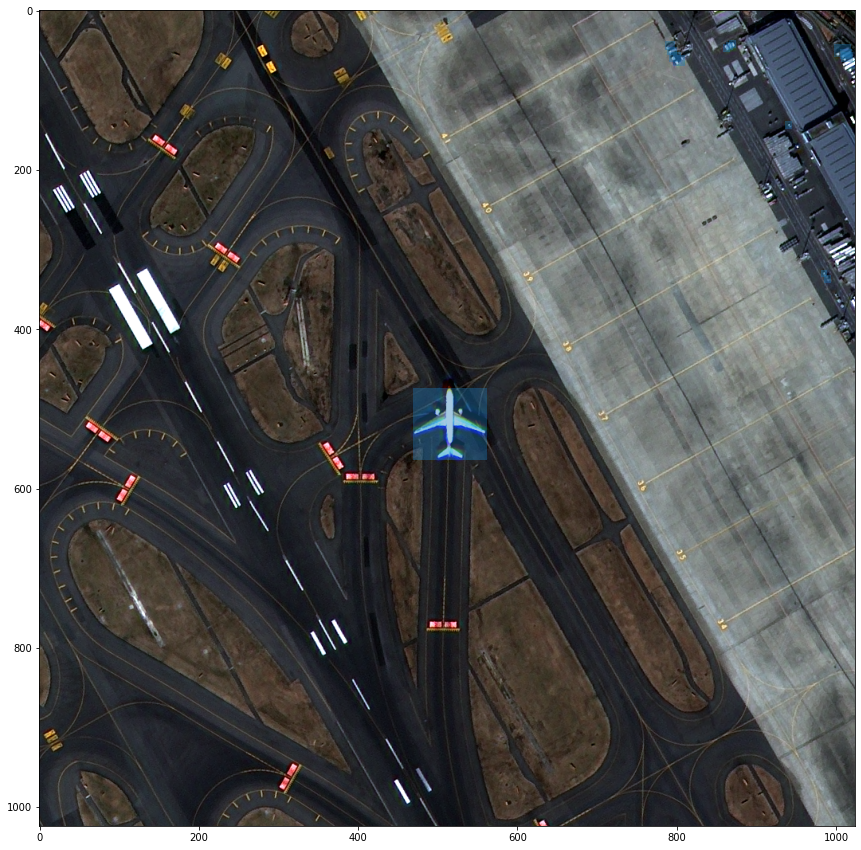

In [ ]:
def visualize(image, bbox):
    plt.rcParams['figure.figsize'] = [15, 15]
    plt.imshow(image)
    ax = plt.gca()
    for box in bbox:
        x, y, w, h = box
        patch = plt.Rectangle([x-w/2, y-h/2], w, h, alpha=0.4)  # 이건 또 x, y 로 해야 맞네...? 무엇;;;;
        ax.add_patch(patch)
    plt.show()
idx = 0
visualize(imgs[idx], bboxs[idx])

Data Preprocessing - AnchorBox and LabelEncoder (from keras.examples - modified)
------

In [ ]:
def convert_to_corners(boxes):  # (x_center, y_center, w, h) => (x_min, y_min, x_max, y_max)
    return tf.concat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1)

def compute_iou(boxes1, boxes2):  # 모든 anchor box, 모든 데이터 박스
    boxes1_corners = convert_to_corners(boxes1)  # anchor 개수, (x_min, y_min, x_max, y_max)
    boxes2_corners = convert_to_corners(boxes2)  # data 개수, (x_min, y_min, x_max, y_max)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

class AnchorBox:               ################################################# AnchorBox
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self): # 모든 feature 에 대해(p3~p7) * 모든 ratio 에 대해 * 모든 scale 에 대해 anchor 크기(x, y) 를 계산하고 넘겨준다.
        anchor_dims_all = []
        for area in self._areas: # 각 feature 에 대해 서로 다른 면적을 사용한다.
            anchor_dims = []
            for ratio in self.aspect_ratios:  # 1:2, 1:1, 2:1
                # 면적은 일정하지만 비율만 다른 anchor 를 만든다.
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape( tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2] ) # 단순히 list 를 tensor로 만들 것이라면 tf.convert_to_tensor 도 가능하긴 함.
                for scale in self.scales:  # 원래 anchor 에 2^0, 2^1/3, 2^2/3 배수를 곱해 추가함..
                    anchor_dims.append(scale * dims)
            # print(anchor_dims)   # 지금은 list 안에 tensor가 있는 꼴 이므로 밑에서 stack 해줌.
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all  # list 안에 각 feature(p3~p7) 별로 ratio, scale 순서대로 합쳐진 상황.
        # (1, 1, 9개의 anchors, 크기 2개=xy)  -  후에 앞 두개 차원에 (원본에서 중앙좌표 x, 원본에서 중앙좌표 y) 넣어주기 위함. (spreadsheet같이)

    def _get_anchors(self, feature_height, feature_width, level):
        '''
        2차원 feature 의 각 중앙값을 meshgrid 하고, 그걸 원본으로 옮겨줌. 즉, 해당 feature 에서 일정간격 뽑고 이를 원본이미지 좌표에 맞춰줌.
        근사하자면, 8*8 인 level 7 은 1024 에서 중앙값 8개를 찾아준거임. (64, 64 + 128, 64 + 128*2, ..., 1024 - 64)
        원본 코드에서 이렇게 한 이유는 안나눠떨어지는애들 처리하려고 이런듯.
        '''
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]  # (rx 개수, ry 개수, 좌표(x,y))
        centers = tf.expand_dims(centers, axis=-2)  # (rx 개수, ry 개수, 1, 좌표(x,y))
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])  # (rx 개수, ry 개수, 9, 좌표(x,y))  -  9 개의 anchor 들이랑 엮어주기 위함.
        dims = tf.tile(self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1])  # 이제 anchor 를 불러와서 (rx 개수, ry 개수, anchor 9개, 크기 xy) 형태로 만들어줌.
        anchors = tf.concat([centers, dims], axis=-1)  # (rx수, ry수, 9, [x, y]) 와 (rx수, ry수, 9, [크기x, 크기y]) 의 concat(-1) => (rx수, ry수, 9, [x, y, 크기x, 크기y])
        return tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4])   # 이제 필요없는 rx수, ry수, 9 는 버리고 [x, y, 크기x, 크기y] 들만 남긴다.

    def get_anchors(self, image_height, image_width):
        anchors = [self._get_anchors( tf.math.ceil(image_height / 2 ** i),tf.math.ceil(image_width / 2 ** i),i) for i in range(3, 8)]
        return tf.concat(anchors, axis=0)
        # 결과적으로, AnchorBox.get_anchors(1024, 1024) 는 tensor[p3의 anchor boxes, p4의 anchor boxes, ..., p7의 anchor boxes] 를 준다.

class LabelEncoder:
    def __init__(self):
        self.anchor_boxes = AnchorBox().get_anchors(1024, 1024)
        self._box_variance = tf.convert_to_tensor( [0.1, 0.1, 0.2, 0.2], dtype=tf.float32 )

    def _match_anchor_boxes(self, gt_boxes, match_iou=0.5, ignore_iou=0.4):
        iou_matrix = compute_iou(self.anchor_boxes, gt_boxes)  # anchor 와 데이터 박스간의 iou 계산.
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (matched_gt_idx, tf.cast(positive_mask, dtype=tf.float32), tf.cast(ignore_mask, dtype=tf.float32) )

    def _compute_box_target(self, matched_gt_boxes):
        box_target = tf.concat([(matched_gt_boxes[:, :2] - self.anchor_boxes[:, :2]) / self.anchor_boxes[:, 2:], tf.math.log(matched_gt_boxes[:, 2:] / self.anchor_boxes[:, 2:])], axis=-1)
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, gt_boxes, cls_ids):  # 하나의 데이터셋이 들어온다.
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)  # 데이터타입을 tf.float32 로 바꿔준다. (np.astype)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(gt_boxes)  # 모든 anchor box 들과 데이터의 box들 비교 => centor로 맞추거나 min으로 맞추거나!!
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)  # idx 가지고 match 된 data box 들만 가져온다.
        box_target = self._compute_box_target(matched_gt_boxes)  
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids)
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        label = tf.where(tf.math.is_nan(label), tf.ones_like(label) * (-1), label)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        batch_size = len(batch_images)
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)  # 크기가 정해진 list(write로 넣고 stack하면 합쳐짐)
        for i in range(batch_size):
            label = self._encode_sample(gt_boxes[i], cls_ids[i])  # 따로 들어가니까 padding 필요 없을 것 같은데?
            labels = labels.write(i, label)
        batch_images = tf.cast(tf.stack(batch_images) / 255, dtype = tf.float32)
        return batch_images, labels.stack()

Data Pipeline
------------

In [ ]:
class Arirang_Dataset(keras.utils.Sequence):
    def __init__(self, imgs, bboxs, ids, batch_size = 1):
        self.pixel, self.bboxs, self.ids = imgs, bboxs, ids
        self.label_encoder = LabelEncoder()
        self.batch_size = batch_size
        if len(imgs) % 4 == 0:
            self.length = len(imgs) // 4
        else:
            self.length = len(imgs) // 4 + 1

    def __getitem__(self, idx):
        i = idx * self.batch_size
        if i + self.batch_size > len(self.ids):
            pixel, bboxs, ids = self.pixel[i:], self.bboxs[i:], self.ids[i:]
        else:
            pixel, bboxs, ids = self.pixel[i:i+self.batch_size], self.bboxs[i:i+self.batch_size], self.ids[i:i+self.batch_size]
        return  self.label_encoder.encode_batch(pixel, bboxs, ids)

    def __len__(self):
        return self.length

train = Arirang_Dataset(imgs, bboxs, ids)
k = train[0]
k[0].shape, k[1].shape

(TensorShape([1, 1024, 1024, 3]), TensorShape([1, 196416, 5]))

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2902, in run_code
    return outflag  File "<ipython-input-37-a28a50fa14e0>", line 23, in <module>
    k = train[0]  File "<ipython-input-37-a28a50fa14e0>", line 17, in __getitem__
    return  self.label_encoder.encode_batch(pixel, bboxs, ids)  File "<ipython-input-36-e5498a9a6208>", line 99, in encode_batch
    batch_images = tf.stack(batch_images) / 255.  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it a

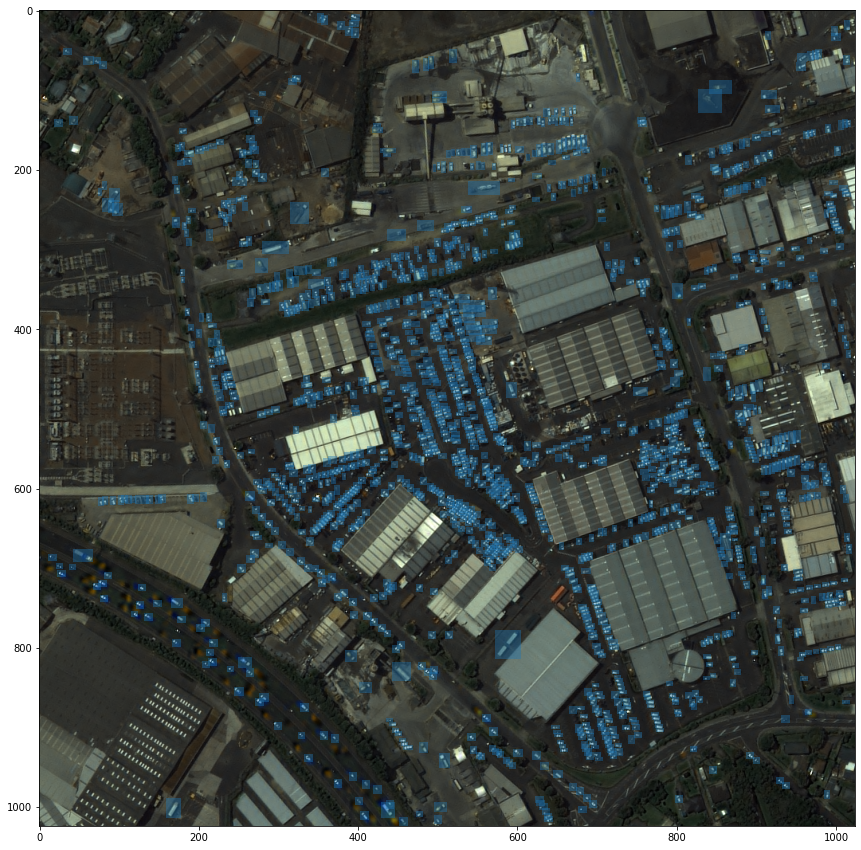

In [ ]:
idx = 235
visualize(imgs[idx], bboxs[idx])

In [ ]:
for i in range(118,len(train)):  # error on 117, 120, ...
    targ = train[i]
    print(i, targ[0].shape, targ[1].shape)

118 (2, 1024, 1024, 3) (2, 196416, 5)
119 (2, 1024, 1024, 3) (2, 196416, 5)


ResourceExhaustedError: ignored

Model
-------

In [ ]:
class RetinaNet(keras.Model):
    def __init__(self, num_classes=16, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        # FPN
        self.backbone = self.get_backbone()
        self.conv_c3_1x1 = layers.Conv2D(256, 1, 1, "same", name = 'c3_fcn')
        self.conv_c4_1x1 = layers.Conv2D(256, 1, 1, "same", name = 'c4_fcn')
        self.conv_c5_1x1 = layers.Conv2D(256, 1, 1, "same", name = 'c5_fcn')
        self.conv_c3_3x3 = layers.Conv2D(256, 3, 1, "same", name = 'c3_fcnn')
        self.conv_c4_3x3 = layers.Conv2D(256, 3, 1, "same", name = 'c4_fcnn')
        self.conv_c5_3x3 = layers.Conv2D(256, 3, 1, "same", name = 'c5_fcnn')
        self.conv_c6_3x3 = layers.Conv2D(256, 3, 2, "same", name = 'c6_fcnn')
        self.conv_c7_3x3 = layers.Conv2D(256, 3, 2, "same", name = 'c7_fcnn')
        self.upsample_2x = layers.UpSampling2D(2)
        # R - CNN (head)
        self.num_classes = num_classes
        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        # 일단 head 를 모두 같게 잡았다. 다르게 한다는 아이디어도 추후 시도
        '''self.cls_heads = self.build_head(9 * num_classes, prior_probability)
        self.box_heads = self.build_head(9 * 4, "zeros")'''
        self.cls_heads = [self.build_head(W, 9 * num_classes, prior_probability) for W in [128, 64, 32, 16, 8]]  # anchor는 9가지 이므로..
        self.box_heads = [self.build_head(W, 9 * 4, "zeros") for W in [128, 64, 32, 16, 8]] # 이걸로 바꾸려면 build_head 부분도 바꾸고 call 마지막에서 zip 으로 바꿔야 한다.

    def get_backbone(self):
        backbone = keras.applications.ResNet50(include_top=False, input_shape=[1024, 1024, 3]) 
        c3_output, c4_output, c5_output = [ backbone.get_layer(layer_name).output for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
        return keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output])

    def build_head(self, W, output_filters, bias_init):
        head = keras.Sequential([keras.Input(shape=[W, W, 256])], name = 'head_'+str(W)) # , name = 'head_'+str(W)
        kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
        for _ in range(4):
            head.add(layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init))
            head.add(layers.ReLU())
        head.add( layers.Conv2D(output_filters, 3, 1, padding="same", kernel_initializer = kernel_init, bias_initializer = bias_init) )
        return head

    def call(self, images):
        # FPN
        c3_output, c4_output, c5_output = self.backbone(images)  # , training = False
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = layers.Add()([p4_output, self.upsample_2x(p5_output)])
        p3_output = layers.Add()([p3_output, self.upsample_2x(p4_output)])
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        # R - CNN head
        features = [p3_output, p4_output, p5_output, p6_output, p7_output]
        N = tf.shape(images)[0]  # = batch_size
        cls_outputs = []
        box_outputs = []
        for feature, box_head, cls_head in zip(features, self.box_heads, self.cls_heads):
            box_outputs.append( tf.reshape(box_head(feature), [N, -1, 4]) )                    # (batch, size of feature, 4 point)
            cls_outputs.append( tf.reshape(cls_head(feature), [N, -1, self.num_classes]) )     # (batch, size of feature, 16 classes)
        cls_outputs = tf.concat(cls_outputs, axis=1)  # batch 는 유지, (모든 feature의 모든 지점들 = anchor box들, 4point)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):  # smooth L1
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(reduction="none", name="RetinaNetBoxLoss")
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where( tf.less(absolute_difference, self._delta), 0.5 * squared_difference, absolute_difference - 0.5 )
        loss = tf.where(tf.math.is_nan(loss), tf.ones_like(loss) * 0.5, loss)
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetClassificationLoss(tf.losses.Loss):  # focal loss
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(reduction="none", name="RetinaNetClassificationLoss")
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        loss = tf.where(tf.math.is_nan(loss), tf.ones_like(loss) * 0.5, loss)
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetLoss(tf.losses.Loss):
    def __init__(self, num_classes=16, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(tf.cast(y_true[:, :, 4], dtype=tf.int32), depth=self._num_classes, dtype=tf.float32)
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

In [ ]:
label_encoder = LabelEncoder()

num_classes = 16

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries = learning_rate_boundaries, values = learning_rates)

check_points = keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_dir, "weights" + "_epoch_{epoch}"), monitor="loss", save_best_only=False, save_weights_only=True, verbose=1)
# Early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True)
callbacks_list = [check_points]

In [ ]:
class CheckpointSave(keras.callbacks.Callback):
    def __init__(self, model_dir, term = 20, spacing = 1):
        super(CheckpointSave, self).__init__()
        self.term = term
        self.model_dir = model_dir
        self.spacing = spacing
        self.candidate_epoch = [self.term - i for i in range(1,spacing + 1)] + [0] + [i for i in range(1,spacing + 1)]
    def on_epoch_end(self, epoch, logs = None):
        if epoch % self.term in self.candidate_epoch:
            current = logs.get("loss")
            if current < 5:
                self.model.save_weights(self.model_dir + str(epoch))
                print("weights saved to : ", self.model_dir + str(epoch))
                self.candidate_epoch = None
        if epoch % self.term == self.spacing + 1:
            self.candidate_epoch = [self.term - i for i in range(1,spacing + 1)] + [0] + [i for i in range(1,spacing + 1)]

callbacks_list = [CheckpointSave(model_dir,20,1)]

In [ ]:
model = RetinaNet()
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
loss_fn = RetinaNetLoss(num_classes)
model.compile(loss=loss_fn, optimizer='adam') # learning_rate_fn
model.fit(train, epochs = 100, verbose = 2, callbacks = callbacks_list)

Epoch 1/100
200/200 - 256s - loss: 16.0743
Epoch 2/100
200/200 - 255s - loss: 28.8547
Epoch 3/100
200/200 - 255s - loss: 39.8947
Epoch 4/100
200/200 - 256s - loss: 1218.1611
Epoch 5/100
200/200 - 255s - loss: 4.3477
Epoch 6/100
200/200 - 256s - loss: 3.7846
Epoch 7/100
200/200 - 256s - loss: 4.0710
Epoch 8/100
200/200 - 257s - loss: 2.6843
Epoch 9/100
200/200 - 257s - loss: 2.7506
Epoch 10/100
200/200 - 256s - loss: 80.9459
Epoch 11/100
200/200 - 255s - loss: 3.1975
Epoch 12/100
200/200 - 257s - loss: 2.6352
Epoch 13/100
200/200 - 257s - loss: 2.5219
Epoch 14/100
200/200 - 258s - loss: 3.2349
Epoch 15/100
200/200 - 258s - loss: 2.5573
Epoch 16/100
200/200 - 258s - loss: 2.5022
Epoch 17/100
200/200 - 258s - loss: 2.4930
Epoch 18/100
200/200 - 258s - loss: 2.5231
Epoch 19/100
200/200 - 258s - loss: 2.4977
Epoch 20/100
200/200 - 256s - loss: 2.4943
Epoch 21/100
weights saved to :  /content/gdrive/My Drive/Dacon/Arirang/retinanet/adam2/20
200/200 - 260s - loss: 2.4915
Epoch 22/100
200/200 

KeyboardInterrupt: ignored

In [ ]:
history.history

{'loss': [3.0096395015716553]}

Prepare Test Data
----------

In [ ]:
def import_testdataset():
    files = glob.glob(path_test + 'images' + '/*.png')
    imgs = []
    tqdm_map = {path : i+1 for i, path in enumerate(files)}
    for path_image in tqdm(tqdm_map, desc='loading the training data'):
        img = Image.open(path_image)
        imgs.append(np.array(img))
    return imgs

imgs_test = import_testdataset()

loading the training data: 0it [00:00, ?it/s]


Decode Predictions for TestData
----------------

In [ ]:
model = RetinaNet()
latest_checkpoint = tf.train.latest_checkpoint(model_dir+'-50')  # 사실 여기서 다운받은 모델을 쓸 수 있다.
model.load_weights(latest_checkpoint)

In [ ]:
model = RetinaNet()
loss_fn = RetinaNetLoss(num_classes)
model.compile(loss=loss_fn, optimizer='adam')
model_dir = '/content/gdrive/My Drive/Dacon/Arirang/retinanet/adam/'
model.load_weights(model_dir + 'weights_epoch_50')

In [ ]:
model = RetinaNet()
weights_dir = "/content/gdrive/My Drive/Dacon/Arirang/retinanet/"
latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

94773248/94765736 [==============================] - 2s 0us/step


AssertionError: ignored

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):
    def __init__(self, num_classes=16, confidence_threshold=0.05, nms_iou_threshold=0.5, max_detections_per_class=2000, max_detections=2000, **kwargs):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self.anchor_box = AnchorBox().get_anchors(1024,1024)
        self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat([boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2], tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:]], axis=-1)
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self.anchor_box
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

image = tf.keras.Input(shape=[1024, 1024, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.03)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [ ]:
inference_model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
RetinaNet (RetinaNet)           (None, None, 20)     57262852    image[0][0]                      
__________________________________________________________________________________________________
decode_predictions (DecodePredi CombinedNonMaxSuppre 0           image[0][0]                      
                                                                 RetinaNet[0][0]                  
Total params: 57,262,852
Trainable params: 57,209,732
Non-trainable params: 53,120
__________________________________________________________________________________________________


(1, 1024, 1024, 3)


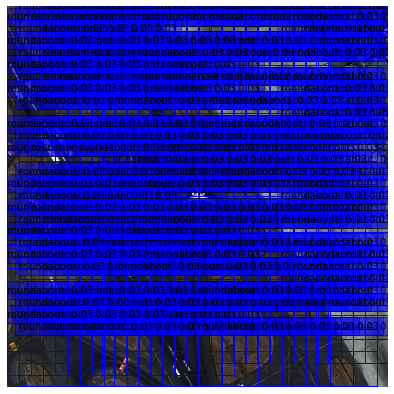

(1, 1024, 1024, 3)


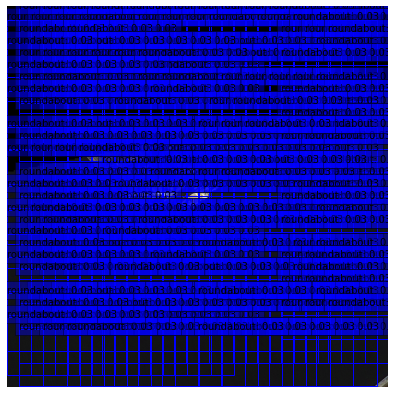

In [ ]:
def visualize_detections(image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle([x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        ax.text(x1,y1,text,bbox={"facecolor": color, "alpha": 0.4},clip_box=ax.clipbox,clip_on=True)
    plt.show()
    return ax

for sample in imgs[:2]:
    input_image = sample.reshape(1,1024,1024,3) / 255
    #input_image = tf.keras.applications.resnet.preprocess_input(sample.reshape(1,1024,1024,3))
    print(input_image.shape)
    # input_image = tf.cast(input_image, dtype=tf.float32)
    detected = inference_model.predict(input_image)
    num_detections = detected.valid_detections[0]
    class_names = [
        int2str[int(x)] for x in detected.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        sample,
        detected.nmsed_boxes[0][:num_detections],
        class_names,
        detected.nmsed_scores[0][:num_detections],
    )

In [ ]:
detected = inference_model.predict(imgs[0].reshape(1,1024,1024,3))
detected

CombinedNonMaxSuppression(nmsed_boxes=array([[[ 31.841827, 579.1184  , 194.8336  , 734.6362  ],
        [703.8418  , 643.1184  , 866.8336  , 798.6362  ],
        [639.8418  , 643.1184  , 802.8336  , 798.6362  ],
        ...,
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ]]], dtype=float32), nmsed_scores=array([[0.03001159, 0.03001159, 0.03001159, ..., 0.        , 0.        ,
        0.        ]], dtype=float32), nmsed_classes=array([[15., 15., 15., ...,  0.,  0.,  0.]], dtype=float32), valid_detections=array([316], dtype=int32))

In [ ]:
np.unique(detected.nmsed_scores[0])

array([0.], dtype=float32)

In [ ]:
model.predict(imgs[-1].reshape(1,1024,1024,3))[0][1]

array([-0.04447359, -0.05304096,  0.5750298 , -0.9860904 , -6.170599  ,
       -4.641266  , -5.142728  , -4.8451996 , -4.821245  , -6.1717296 ,
       -5.324359  , -4.692512  , -4.7604585 , -5.010321  , -6.1615305 ,
       -4.936481  , -6.170117  , -6.1644773 , -4.7400446 , -5.2344007 ],
      dtype=float32)